In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, ParameterGrid

import matplotlib.pyplot as plt
import utils
import pandas as pd

2022-04-09 19:41:24.573531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 19:41:24.573586: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#MAIN_PATH = "/mnt/homeGPU/fcastro/MINDAT_AVAN/fran/"
MAIN_PATH = "/home/franblue/PROYECTOS/lulc/"

#data_dir = "../reduced_data/"
data_dir = MAIN_PATH + "data/"
batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_data, train_labels, test_data, test_labels, test_names = utils.load_data(data_dir, norm=False)

In [4]:
idx = np.logical_or(train_labels==20, train_labels==21)
train_data = train_data[idx]
train_data=train_data/255.0
train_labels = train_labels[idx]

idx = np.logical_or(test_labels==20, test_labels==21)
test_data = test_data[idx]
test_data=test_data/255.0
test_labels = test_labels[idx]

In [5]:
fl_train_data = train_data.reshape(train_data.shape[0], -1)
fl_test_data = test_data.reshape(test_data.shape[0], -1)

In [6]:
#hsv_train_data = tf.image.rgb_to_hsv(train_data).numpy()
#fl_hsv_train_data = hsv_train_data.reshape(hsv_train_data.shape[0], -1)

#hsv_test_data = tf.image.rgb_to_hsv(test_data).numpy()
#fl_hsv_test_data = hsv_test_data.reshape(hsv_test_data.shape[0], -1)

In [7]:
#fl_train_data = np.concatenate((fl_train_data, fl_hsv_train_data), axis=1)
#fl_test_data = np.concatenate((fl_test_data, fl_hsv_test_data), axis=1)
#fl_train_data = fl_hsv_train_data
#fl_test_data = fl_hsv_test_data

In [8]:
pca = PCA(n_components=708)
pca = pca.fit(fl_train_data)

Text(750, 0.99, 'y=0.99')

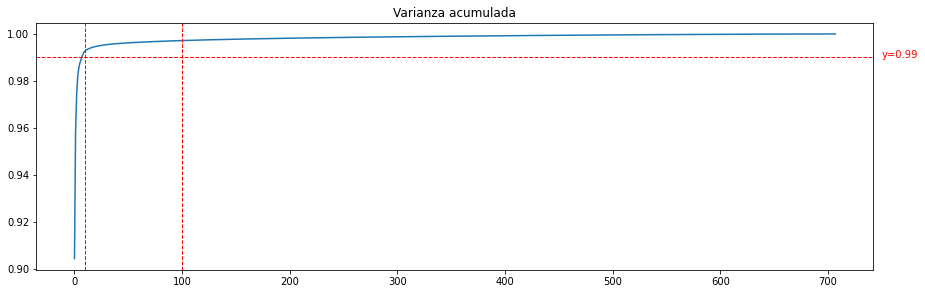

In [26]:
cumsum=np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(cumsum/cumsum[-1])
plt.title('Varianza acumulada')
plt.axvline(x=10, color='red', linewidth=1, linestyle='--')
plt.axvline(x=100, color='red', linewidth=1,linestyle='--')
plt.axhline(y=0.99, color='red', linewidth=1,linestyle='--')
plt.text(x=750, y=0.99, s="y=0.99", color='red')

In [ ]:
fl_train_data_trans = pca.transform(fl_train_data)[:,0:n_components]
fl_test_data_trans = pca.transform(fl_test_data)[:,0:n_components]

In [ ]:
idx_20 = train_labels==20
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(fl_train_data_trans[idx_20,0], fl_train_data_trans[idx_20,1], label="20")
idx_21 = train_labels==21
ax.scatter(fl_train_data_trans[idx_21,0], fl_train_data_trans[idx_21,1], label="21")
plt.legend()

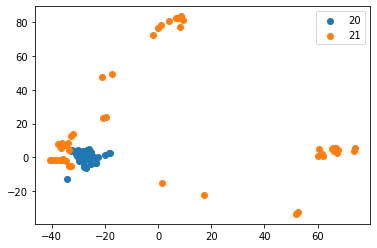

In [136]:
idx_20 = test_labels==20
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(fl_test_data_trans[idx_20,0], fl_test_data_trans[idx_20,1], label="20")
idx_21 = test_labels==21
ax.scatter(fl_test_data_trans[idx_21,0], fl_test_data_trans[idx_21,1], label="21")
plt.legend()

In [137]:
param_dic = {"C" : [0.0001, 0.001, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 10.0], "gamma" : [0.0001, 0.001, 0.1, 1.0, 2.0, 5.0]}

param_grid = ParameterGrid(param_dic)

In [138]:
svm = SVC(kernel="rbf")
gs = GridSearchCV(svm, param_dic)
gs = gs.fit(fl_train_data_trans, train_labels)

In [139]:
print(gs.best_params_)
print(gs.best_score_)

{'C': 3.0, 'gamma': 0.001}
0.7739986015383079


In [140]:
svm = SVC(C=gs.best_params_["C"], kernel="rbf", gamma=gs.best_params_["gamma"])
#svm = SVC(C=10.0, kernel="rbf", gamma=0.1)
svm = svm.fit(fl_train_data_trans, train_labels)

In [141]:
train_preds = svm.predict(fl_train_data_trans)
print(classification_report(train_labels, train_preds))

              precision    recall  f1-score   support

          20       0.78      0.88      0.82       354
          21       0.86      0.75      0.80       354

    accuracy                           0.81       708
   macro avg       0.82      0.81      0.81       708
weighted avg       0.82      0.81      0.81       708



In [142]:
test_preds = svm.predict(fl_test_data_trans)
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

          20       0.80      0.87      0.83        52
          21       0.85      0.78      0.82        51

    accuracy                           0.83       103
   macro avg       0.83      0.82      0.82       103
weighted avg       0.83      0.83      0.82       103



In [143]:
acc_train_list = []
acc_test_list = []
for d in param_grid:
    svm = SVC(C=d["C"], kernel="rbf", gamma=d["gamma"])
    svm = svm.fit(fl_train_data_trans, train_labels)
    train_preds = svm.predict(fl_train_data_trans)
    acc_train = accuracy_score(train_labels, train_preds)
    test_preds = svm.predict(fl_test_data_trans)
    acc_test = accuracy_score(test_labels, test_preds)
    print(f"C={d['C']}, gamma={d['gamma']}, acc_train={acc_train}, acc_test={acc_test}")

C=0.0001, gamma=0.0001, acc_train=0.6200564971751412, acc_test=0.6601941747572816
C=0.0001, gamma=0.001, acc_train=0.6680790960451978, acc_test=0.7572815533980582
C=0.0001, gamma=0.1, acc_train=0.6002824858757062, acc_test=0.7669902912621359
C=0.0001, gamma=1.0, acc_train=0.614406779661017, acc_test=0.6116504854368932
C=0.0001, gamma=2.0, acc_train=1.0, acc_test=0.5922330097087378
C=0.0001, gamma=5.0, acc_train=1.0, acc_test=0.5145631067961165
C=0.001, gamma=0.0001, acc_train=0.6200564971751412, acc_test=0.6601941747572816
C=0.001, gamma=0.001, acc_train=0.6680790960451978, acc_test=0.7572815533980582
C=0.001, gamma=0.1, acc_train=0.6002824858757062, acc_test=0.7669902912621359
C=0.001, gamma=1.0, acc_train=0.614406779661017, acc_test=0.6116504854368932
C=0.001, gamma=2.0, acc_train=1.0, acc_test=0.5922330097087378
C=0.001, gamma=5.0, acc_train=1.0, acc_test=0.5145631067961165
C=0.1, gamma=0.0001, acc_train=0.6638418079096046, acc_test=0.6699029126213593
C=0.1, gamma=0.001, acc_train=0

In [144]:
svm = SVC(C=1.0, kernel="rbf", gamma=0.1)
#svm = SVC(C=10.0, kernel="rbf", gamma=0.1)
svm = svm.fit(fl_train_data_trans, train_labels)

In [145]:
train_preds = svm.predict(fl_train_data_trans)
print(classification_report(train_labels, train_preds))

              precision    recall  f1-score   support

          20       0.97      0.98      0.97       354
          21       0.98      0.97      0.97       354

    accuracy                           0.97       708
   macro avg       0.97      0.97      0.97       708
weighted avg       0.97      0.97      0.97       708



In [146]:
test_preds = svm.predict(fl_test_data_trans)
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

          20       0.93      0.98      0.95        52
          21       0.98      0.92      0.95        51

    accuracy                           0.95       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.95      0.95      0.95       103

